# Table of Contents
* [TODO](#TODO)
* [Imports](#Imports)
* [Utils](#Utils)
	* [Modules](#Modules)
		* [init_weights (net, init_type=('normal', ['normal', 'xavier', 'kaiming', 'orthogonal']), gain=0.02)](#init_weights-%28net,-init_type=%28'normal',-['normal',-'xavier',-'kaiming',-'orthogonal']%29,-gain=0.02%29)
* [Modules](#Modules)
	* [Backbone](#Backbone)
	* [Midreps](#Midreps)
	* [Decoder](#Decoder)
	* [Discriminator (TODO)](#Discriminator-%28TODO%29)
* [Losses (TODO)](#Losses-%28TODO%29)
* [Data Processing (TODO)](#Data-Processing-%28TODO%29)


# TODO

* [ ] Configs
    * [ ] Autoencoder
* [ ] Networks
    * [ ] Backbone
        * [x] Architecture
        * [ ] Initialization
    * [ ] Midreps
        * [x] Architecture
        * [ ] Initialization
    * [ ] Decoder
        * [x] Architecture
        * [ ] Initialization
    * [ ] Pix2Pix Discriminator
        * [ ] Architecture
        * [ ] Initialization
    * [ ] PixelGAN Discriminator
        * [ ] Architecture
        * [ ] Initialization
* [ ] Data
* [ ] Training
    * [ ] Weight decay
    * [ ] Multitask multipliers

# Imports

In [140]:
import functools
from easydict import EasyDict as edict

import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F

import pytorch_lightning as pl
from torchsummaryX import summary

import visualpriors

# Configs

## Autoencoder (ae_cfg)

In [130]:
ae_cfg = edict()

ae_cfg.train = edict()
ae_cfg.train.num_epochs = 30
ae_cfg.train.weight_decay = edict()
ae_cfg.train.weight_decay.default = 2e-6
ae_cfg.train.weight_decay.discriminator = 10 * ae_cfg.train.weight_decay.default

ae_cfg.model = edict()
ae_cfg.model.discriminator = edict()
ae_cfg.model.discriminator.type = 'nlayerdicriminator'
ae_cfg.model.discriminator.n_layers = 5
ae_cfg.model.discriminator.stride = 4
ae_cfg.model.discriminator.n_channel_multiplier = 64

## Euclidean Depth (depth_cfg)

In [137]:
depth_cfg = edict()

depth_cfg.train = edict()
depth_cfg.train.num_epochs = 30
depth_cfg.train.weight_decay = edict()
depth_cfg.train.weight_decay.default = 2e-6
depth_cfg.train.weight_decay.discriminator = 10 * depth_cfg.train.weight_decay.default
depth_cfg.train.lambdas = edict()
depth_cfg.train.lambdas.lnorm = 0.996
depth_cfg.train.lambdas.gan = 0.004
depth_cfg.train.lrs = edict()
depth_cfg.train.lrs.default = 1e-4
depth_cfg.train.lrs.discriminator = 1e-5


depth_cfg.model = edict()

depth_cfg.model.backbone = edict()
depth_cfg.model.backbone.kwargs = edict()

depth_cfg.model.midreps = edict()
depth_cfg.model.midreps.kwargs = edict()
depth_cfg.model.midreps.kwargs.normalize_outputs = True

depth_cfg.model.decoder = edict()
depth_cfg.model.decoder.kwargs = edict()
depth_cfg.model.decoder.kwargs.output_act = 'sigmoid'
depth_cfg.model.decoder.kwargs.out_channels = 1

depth_cfg.model.discriminator = edict()
depth_cfg.model.discriminator.type = 'nlayerdicriminator'
depth_cfg.model.discriminator.kwargs = edict()
depth_cfg.model.discriminator.kwargs.n_layers = 5
depth_cfg.model.discriminator.kwargs.stride = 4
depth_cfg.model.discriminator.kwargs.ndf = 64

# Utils

## Modules

### acts = {'none', 'tanh', 'sigmoid'}

In [127]:
acts = {'none': nn.Identity, 'tanh': nn.Tanh, 'sigmoid': nn.Sigmoid}

### init_weights(net, init_type=('normal', ['normal', 'xavier', 'kaiming', 'orthogonal']), gain=0.02)

In [10]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

## Misc

# Models

## PLModel(cfg)

In [173]:
class PLModel(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        model_cfg = cfg.model
        
        self.backbone = Backbone(**model_cfg.backbone.kwargs)
        self.midreps = MidReps(**model_cfg.midreps.kwargs)
        self.decoder = Decoder(**model_cfg.decoder.kwargs)
        
        self.discriminator = None
        if 'discriminator' in model_cfg and bool(model_cfg.discriminator):
            self.discriminator = NLayerDiscriminator(
                input_nc=6,
                **model_cfg.discriminator.kwargs
            )
        
    
    def forward(self, x):
        bb_feats = self.backbone(x)
        midreps = self.midreps(bb_feats)
        return self.decoder(midreps), edict(backbone=bb_feats, midreps=midreps)
    
    def training_step(self, batch, batch_nb):
        recon, feats = self(x)
        

In [174]:
model = PLModel(depth_cfg)
model

PLModel(
  (backbone): Backbone(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [175]:
PLModel(depth_cfg)(torch.randn(1, 3, 224, 224))

(tensor([[[[0.4998, 0.4784, 0.5329,  ..., 0.5388, 0.5302, 0.5198],
           [0.4909, 0.4996, 0.5076,  ..., 0.4517, 0.4983, 0.5062],
           [0.4791, 0.5140, 0.5050,  ..., 0.5038, 0.4804, 0.5048],
           ...,
           [0.5042, 0.5387, 0.5457,  ..., 0.5011, 0.5457, 0.6106],
           [0.4824, 0.4816, 0.4859,  ..., 0.4492, 0.4644, 0.4598],
           [0.5533, 0.5091, 0.5052,  ..., 0.5615, 0.5037, 0.4686]]]],
        grad_fn=<SigmoidBackward>),
 {'backbone': tensor([[[[0.5634, 1.3340, 0.0000,  ..., 0.6591, 0.0000, 0.0000],
            [0.0000, 1.4594, 0.0000,  ..., 0.0000, 0.0000, 0.8894],
            [0.0000, 0.0000, 1.5629,  ..., 1.4387, 5.2043, 0.1883],
            ...,
            [0.0333, 0.0000, 3.3803,  ..., 0.0000, 3.5210, 1.5130],
            [0.5759, 1.0167, 1.2920,  ..., 0.1733, 2.9381, 1.3073],
            [0.0000, 2.8858, 1.6189,  ..., 0.4273, 0.4278, 0.7137]],
  
           [[0.4749, 1.5442, 0.8364,  ..., 0.0000, 2.8640, 0.5206],
            [0.0000, 0.0080, 0.000

### rescale(data, low, high)

In [126]:
def rescale(data, low, high):
    return (data - low) / (high - low)

# Modules

## Backbone()

In [2]:
# For making a (Hp x Wp x 2048) feature map commmon for all tasks
class Backbone(visualpriors.taskonomy_network.TaskonomyEncoder):
    def __init__(self):
    # def __init__(self, normalize_outputs=True, eval_only=True, train_penultimate=False, train=False):
        self.inplanes = 64
        super(visualpriors.taskonomy_network.TaskonomyEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True)
        block = visualpriors.taskonomy_network.Bottleneck
        layers = [3,4,6,3]
        self.layer1 = self._make_layer(block, 64, layers[0], stride=2)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2])
        self.layer4 = self._make_layer(block, 512, layers[3])
        # self.compress1 = nn.Conv2d(2048, 8, kernel_size=3, stride=1, padding=1, bias=False)
        # self.compress_bn = nn.BatchNorm2d(8)
        # self.relu1 = nn.ReLU(inplace=True)
        # self.groupnorm = nn.GroupNorm(8, 8, affine=False)
        # self.normalize_outputs = normalize_outputs
        # self.eval_only = eval_only
        # if self.eval_only:
        #     self.eval()
        # for p in self.parameters():
        #     p.requires_grad = False

        # if train_penultimate:
        #     for name, param in self.named_parameters():
        #         if 'compress' in name:  # last layers: compress1.weight, compress_bn.weight, compress_bn.bias
        #             param.requires_grad = True
        #         else:
        #             param.requires_grad = False

        # if train:
        #     for p in self.parameters():
        #         p.requires_grad = True
        
    def forward(self, x):
        x = F.pad(x, pad=(3,3,3,3), mode='constant', value=0)
        #  other modes are reflect, replicate, constant

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = F.pad(x, (0,1,0,1), 'constant', 0)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # x = self.compress1(x)
        # x = self.compress_bn(x)
        # x = self.relu1(x)
        # if self.normalize_outputs:
        #     x = self.groupnorm(x)
        return x
    
    def train(self, val=True):
        # if val and self.eval_only:
        #     warnings.warn("Ignoring 'train()' in TaskonomyEncoder since 'eval_only' was set during initialization.", RuntimeWarning)
        # else:
        # return super(TaskonomyEncoder, self).train(val)
        return nn.Module.train(self, val)

In [3]:
backbone = Backbone()
summary(backbone, torch.randn(1, 3, 224, 224))

                                             Kernel Shape       Output Shape  \
Layer                                                                          
0_conv1                                     [3, 64, 7, 7]  [1, 64, 112, 112]   
1_bn1                                                [64]  [1, 64, 112, 112]   
2_relu                                                  -  [1, 64, 112, 112]   
3_maxpool                                               -    [1, 64, 56, 56]   
4_layer1.0.Conv2d_conv1                    [64, 64, 1, 1]    [1, 64, 56, 56]   
5_layer1.0.BatchNorm2d_bn1                           [64]    [1, 64, 56, 56]   
6_layer1.0.ReLU_relu                                    -    [1, 64, 56, 56]   
7_layer1.0.Conv2d_conv2                    [64, 64, 3, 3]    [1, 64, 56, 56]   
8_layer1.0.BatchNorm2d_bn2                           [64]    [1, 64, 56, 56]   
9_layer1.0.ReLU_relu                                    -    [1, 64, 56, 56]   
10_layer1.0.Conv2d_conv3                

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_conv1,"[3, 64, 7, 7]","[1, 64, 112, 112]",9408.0,118013952.0
1_bn1,[64],"[1, 64, 112, 112]",128.0,64.0
2_relu,-,"[1, 64, 112, 112]",NaN,NaN
3_maxpool,-,"[1, 64, 56, 56]",NaN,NaN
4_layer1.0.Conv2d_conv1,"[64, 64, 1, 1]","[1, 64, 56, 56]",4096.0,12845056.0
5_layer1.0.BatchNorm2d_bn1,[64],"[1, 64, 56, 56]",128.0,64.0
6_layer1.0.ReLU_relu,-,"[1, 64, 56, 56]",NaN,NaN
7_layer1.0.Conv2d_conv2,"[64, 64, 3, 3]","[1, 64, 56, 56]",36864.0,115605504.0
8_layer1.0.BatchNorm2d_bn2,[64],"[1, 64, 56, 56]",128.0,64.0


## Midreps(normalize_outputs=True)

In [4]:
# Transform the (Hp x Wp x 2048) feature map to a task-specific feature map of (Hp x Wp x 8)
class MidReps(nn.Module):
    def __init__(self, normalize_outputs=True):
        super().__init__()
        self.compress1 = nn.Conv2d(2048, 8, kernel_size=3, stride=1, padding=1, bias=False)
        self.compress_bn = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU(inplace=True)
        self.normalize_outputs = normalize_outputs
        if self.normalize_outputs:
            self.groupnorm = nn.GroupNorm(8, 8, affine=False)
        
    def forward(self, x):
        x = self.compress1(x)
        x = self.compress_bn(x)
        x = self.relu1(x)
        if self.normalize_outputs:
            x = self.groupnorm(x)
        return x

In [5]:
midreps = MidReps()
summary(midreps, backbone(torch.randn(1, 3, 224, 224)))

                  Kernel Shape    Output Shape    Params   Mult-Adds
Layer                                                               
0_compress1    [2048, 8, 3, 3]  [1, 8, 14, 14]  147.456k  28.901376M
1_compress_bn              [8]  [1, 8, 14, 14]      16.0         8.0
2_relu1                      -  [1, 8, 14, 14]         -           -
3_groupnorm                  -  [1, 8, 14, 14]         -           -
--------------------------------------------------------------------
                          Totals
Total params            147.472k
Trainable params        147.472k
Non-trainable params         0.0
Mult-Adds             28.901384M


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_compress1,"[2048, 8, 3, 3]","[1, 8, 14, 14]",147456.0,28901376.0
1_compress_bn,[8],"[1, 8, 14, 14]",16.0,8.0
2_relu1,-,"[1, 8, 14, 14]",NaN,NaN
3_groupnorm,-,"[1, 8, 14, 14]",NaN,NaN


## Decoder(output_act='none', out_channels=3, *args, **kwargs)

In [128]:
# Decode the (Hp x Wp x 8) feature map to it's specific task
class Decoder(visualpriors.taskonomy_network.TaskonomyDecoder):
    def __init__(self, output_act='none', out_channels=3, eval_only=False, *args, **kwargs):
        super().__init__(out_channels=out_channels, eval_only=eval_only, *args, **kwargs)
        self.output_act = output_act
        act = acts[output_act]()
            
        self.decoder_output = nn.Sequential(
            nn.Conv2d(16, out_channels, kernel_size=3, stride=1, bias=True, padding=1),
            act,
        )  

In [7]:
decoder = Decoder()
summary(decoder, midreps(backbone(torch.randn(1, 3, 224, 224))))

                                     Kernel Shape       Output Shape Params  \
Layer                                                                         
0_conv2.Conv2d_0                  [8, 1024, 3, 3]  [1, 1024, 14, 14]      -   
1_conv2.BatchNorm2d_1                      [1024]  [1, 1024, 14, 14]      -   
2_conv2.LeakyReLU_2                             -  [1, 1024, 14, 14]      -   
3_conv3.Conv2d_0               [1024, 1024, 3, 3]  [1, 1024, 14, 14]      -   
4_conv3.BatchNorm2d_1                      [1024]  [1, 1024, 14, 14]      -   
5_conv3.LeakyReLU_2                             -  [1, 1024, 14, 14]      -   
6_conv4.Conv2d_0                [1024, 512, 3, 3]   [1, 512, 14, 14]      -   
7_conv4.BatchNorm2d_1                       [512]   [1, 512, 14, 14]      -   
8_conv4.LeakyReLU_2                             -   [1, 512, 14, 14]      -   
9_conv5.Conv2d_0                 [512, 256, 3, 3]   [1, 256, 14, 14]      -   
10_conv5.BatchNorm2d_1                      [256]   

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_conv2.Conv2d_0,"[8, 1024, 3, 3]","[1, 1024, 14, 14]",NaN,NaN
1_conv2.BatchNorm2d_1,[1024],"[1, 1024, 14, 14]",NaN,NaN
2_conv2.LeakyReLU_2,-,"[1, 1024, 14, 14]",NaN,NaN
3_conv3.Conv2d_0,"[1024, 1024, 3, 3]","[1, 1024, 14, 14]",NaN,NaN
4_conv3.BatchNorm2d_1,[1024],"[1, 1024, 14, 14]",NaN,NaN
5_conv3.LeakyReLU_2,-,"[1, 1024, 14, 14]",NaN,NaN
6_conv4.Conv2d_0,"[1024, 512, 3, 3]","[1, 512, 14, 14]",NaN,NaN
7_conv4.BatchNorm2d_1,[512],"[1, 512, 14, 14]",NaN,NaN
8_conv4.LeakyReLU_2,-,"[1, 512, 14, 14]",NaN,NaN


## Discriminator (TODO)

### NLayerDiscriminator(input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False)

In [73]:
class NLayerDiscriminator(nn.Module):
    def __init__(self,
                 input_nc,
                 ndf=64,
                 n_layers=3,
                 norm_layer=nn.BatchNorm2d,
                 stride=2,
                 use_sigmoid=False,
                 out_pool=True,
                ):
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc,
                      ndf,
                      kernel_size=kw,
                      stride=stride,
                      padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev,
                          ndf * nf_mult,
                          kernel_size=kw,
                          stride=stride,
                          padding=padw,
                          bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev,
                      ndf * nf_mult,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [
            nn.Conv2d(ndf * nf_mult, 1, kernel_size=4, stride=1, padding=0)
        ]
        if out_pool:
            sequence += [nn.AdaptiveAvgPool2d((1, 1))]

        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)

In [74]:
nlayer_discriminator = NLayerDiscriminator(
    input_nc=3,
    n_layers=ae_cfg.model.discriminator.n_layers,
    ndf=ae_cfg.model.discriminator.n_channel_multiplier,
    # stride=ae_cfg.model.discriminator.stride,
    stride=2,
)
print(nlayer_discriminator)
summary(nlayer_discriminator, torch.randn(1, 3, 224, 224))

NLayerDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momen

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_model.Conv2d_0,"[3, 64, 4, 4]","[1, 64, 112, 112]",3136.0,38535168.0
1_model.LeakyReLU_1,-,"[1, 64, 112, 112]",NaN,NaN
2_model.Conv2d_2,"[64, 128, 4, 4]","[1, 128, 56, 56]",131072.0,411041792.0
3_model.BatchNorm2d_3,[128],"[1, 128, 56, 56]",256.0,128.0
4_model.LeakyReLU_4,-,"[1, 128, 56, 56]",NaN,NaN
5_model.Conv2d_5,"[128, 256, 4, 4]","[1, 256, 28, 28]",524288.0,411041792.0
6_model.BatchNorm2d_6,[256],"[1, 256, 28, 28]",512.0,256.0
7_model.LeakyReLU_7,-,"[1, 256, 28, 28]",NaN,NaN
8_model.Conv2d_8,"[256, 512, 4, 4]","[1, 512, 14, 14]",2097152.0,411041792.0


### PixelDiscriminator(input_nc, ndf=64, norm_layer=nn.BatchNorm2d, use_sigmoid=False)

In [15]:
class PixelDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, norm_layer=nn.BatchNorm2d, use_sigmoid=False):
        super(PixelDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.net = [
            nn.Conv2d(input_nc, ndf, kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=1, stride=1, padding=0, bias=use_bias),
            norm_layer(ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 2, 1, kernel_size=1, stride=1, padding=0, bias=use_bias)]

        if use_sigmoid:
            self.net.append(nn.Sigmoid())

        self.net = nn.Sequential(*self.net)

    def forward(self, input):
        return self.net(input)

In [17]:
PixelDiscriminator(3)

PixelDiscriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
)

# Losses (TODO)

# Data Processing (TODO)

# Scratchpad

## Depthmap

In [76]:
import numpy as np
from PIL import Image

In [103]:
img = Image.open('/Users/sebamenabar/Downloads/taskonomy-sample-model-1-master/depth_euclidean/point_0_view_0_domain_depth_euclidean.png')
# img = img.convert('RGB')

In [104]:
import numpy as np

In [105]:
def resize_and_rescale_image_log( img, new_dims, offset=1., normalizer=1.):
    """
        Resizes and rescales an img to log-linear
        
        Args:
            img: A np array
            offset: Shifts values by offset before taking log. Prevents 
                taking the log of a negative number
            normalizer: divide by the normalizing factor after taking log
        Returns:
            rescaled_image
    """
    img =  np.log( float( offset ) + img ) / normalizer 
    # img = resize_image(img, new_dims)
    return img

In [106]:
import matplotlib.pyplot as plt

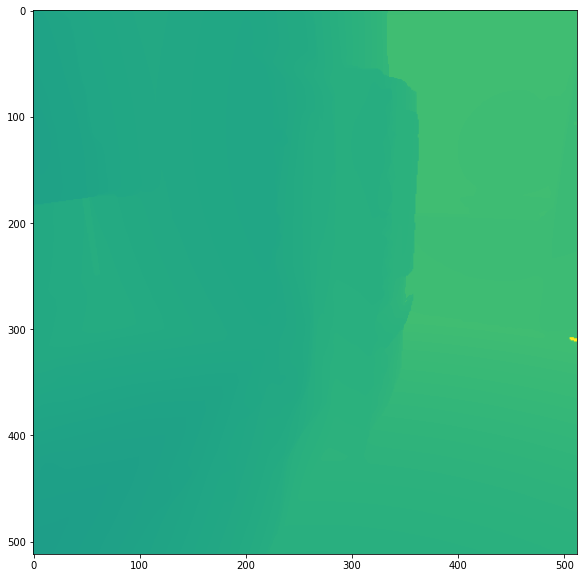

In [124]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(resize_and_rescale_image_log(np.array(img), None, 1, np.log( 2. ** 16.0 )), vmin=0, vmax=1)

In [95]:
from PIL import Image
import torchvision.transforms.functional as TF
import visualpriors



In [110]:
image = Image.open('/Users/sebamenabar/Downloads/taskonomy-sample-model-1-master/rgb/point_0_view_0_domain_rgb.png').convert('RGB')

x = TF.to_tensor(TF.resize(image, (256, 256))) * 2 - 1
x = x.unsqueeze_(0)

feature = 'depth_euclidean'

# Transform to normals feature
# representation = visualpriors.representation_transform(x, feature, device='cpu')

# Transform to normals feature and then visualize the readout
pred = visualpriors.feature_readout(x, feature, device='cpu')

In [112]:
pred

tensor([[[[0.4580, 0.6182, 0.6172,  ..., 0.6961, 0.6585, 0.6400],
          [0.5832, 0.6112, 0.6088,  ..., 0.6989, 0.6892, 0.6608],
          [0.6084, 0.6062, 0.6187,  ..., 0.6977, 0.6940, 0.6829],
          ...,
          [0.5305, 0.5559, 0.5572,  ..., 0.6338, 0.6361, 0.5982],
          [0.5524, 0.5534, 0.5553,  ..., 0.6267, 0.6285, 0.6147],
          [0.5226, 0.5184, 0.5391,  ..., 0.5963, 0.6334, 0.5019]]]])

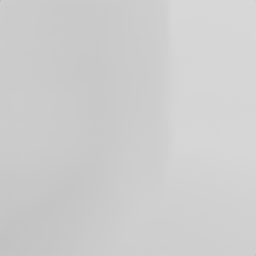

In [111]:
TF.to_pil_image(pred[0] / 2. + 0.5)

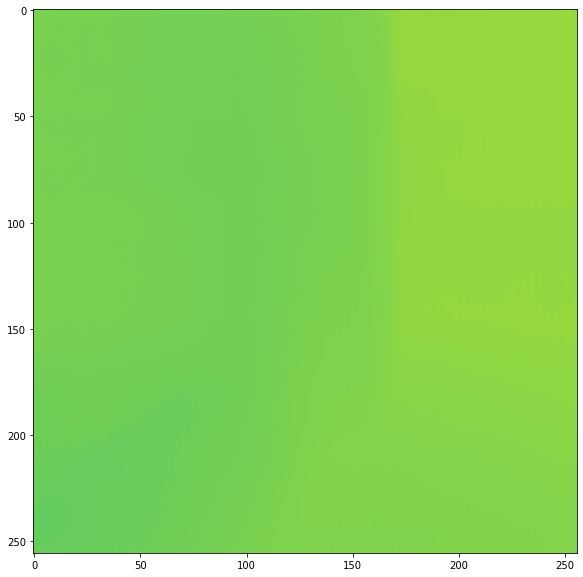

In [121]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(pred[0][0] / 2. + 0.5, vmin=0, vmax=1)

In [119]:
(pred[0][0] / 2. + 0.5).min()

tensor(0.7290)

In [120]:
resize_and_rescale_image_log(np.array(img), None, 1, np.log( 2. ** 16.0 )).min()

0.5598188775976429